# Simulations de l'expérience  <a class="tocSkip">

Nous voulons réaliser des simulations aussi proches que possible de l'expérience réelle, en prenant en compte à la fois les mutations impactant les taux de croissance selon une DFE, la croissance des bactéries et le bruit des mesures.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importer-les-données-réelles" data-toc-modified-id="Importer-les-données-réelles-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importer les données réelles</a></span></li><li><span><a href="#Simulation-réaliste" data-toc-modified-id="Simulation-réaliste-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulation réaliste</a></span><ul class="toc-item"><li><span><a href="#Tirage-des-effets-des-mutations" data-toc-modified-id="Tirage-des-effets-des-mutations-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Tirage des effets des mutations</a></span></li><li><span><a href="#Evolution-des-taux-de-mutation" data-toc-modified-id="Evolution-des-taux-de-mutation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Evolution des taux de mutation</a></span></li><li><span><a href="#Bruit-proche-de-celui-de-l'expérience" data-toc-modified-id="Bruit-proche-de-celui-de-l'expérience-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Bruit proche de celui de l'expérience</a></span></li><li><span><a href="#Figure-bilan" data-toc-modified-id="Figure-bilan-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Figure bilan</a></span></li></ul></li><li><span><a href="#Animations" data-toc-modified-id="Animations-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Animations</a></span><ul class="toc-item"><li><span><a href="#Réplicats" data-toc-modified-id="Réplicats-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Réplicats</a></span></li></ul></li></ul></div>

In [8]:
%matplotlib inline

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation, rc
import pandas as pd
import csv
from scipy import stats

file="Donnees_article/All_data/data_microMA/dataset_microMA_MutH.csv"

In [10]:
from IPython.display import display, HTML, Video
CSS = """.output {align-items: center;}"""
HTML('<style>{}</style>'.format(CSS))

# Importer les données réelles

In [11]:
growthR_real_df = pd.read_csv(file, 
                      sep = ";", 
                      decimal=",", 
                      usecols=range(2,1476*3+1,3), 
                      skiprows=[1,2])
growthR_real_df.iloc[:5, :5]

,growth.rate,growth.rate.1,growth.rate.2,growth.rate.3,growth.rate.4
0,0.03527,0.032026,0.028119,0.029765,NaN
1,0.03527,0.032026,0.028119,0.029765,0.033812
2,0.03247,0.032026,0.026802,0.030567,0.033812
3,0.03247,0.032026,0.026802,0.030567,0.033812
4,0.03247,0.033672,0.026802,0.030567,0.033812


In [12]:
growthR_real_array = growthR_real_df.to_numpy()

In [13]:
exp_shape = np.shape(growthR_real_array)
print(exp_shape)

(1000, 1476)


In [14]:
growthR_real_array

array([[3.5269650e-02, 3.2025912e-02, 2.8119496e-02, ..., 2.3454689e-02,
        1.8758796e-02,           nan],
       [3.5269650e-02, 3.2025912e-02, 2.8119496e-02, ..., 2.3454689e-02,
        1.8758796e-02, 2.5567243e-02],
       [3.2470449e-02, 3.2025912e-02, 2.6801815e-02, ..., 2.6620318e-02,
        3.0876094e-02, 2.5567243e-02],
       ...,
       [2.8670487e-02, 1.6752654e-02, 2.5671465e-02, ..., 4.7900000e-05,
        2.6452291e-02, 0.0000000e+00],
       [2.8670487e-02, 1.6752654e-02, 2.5671465e-02, ..., 4.7900000e-05,
        2.6452291e-02, 0.0000000e+00],
       [2.8670487e-02, 1.6752654e-02, 2.5671465e-02, ..., 4.7900000e-05,
        2.6452291e-02, 0.0000000e+00]])

In [15]:
# Distribution initiale des taux de croissances
#growthR_init = growthR_real_array[:,0]   # première génération de l'expérience (comprenant des taux de croissance aberrants et des NAs)
growthR_init = np.array([np.median([l for l in d if not np.isnan(l)]) for d in growthR_real_array.T[:,:10]])   # médiane des 10 premières mesures
growthR_init[growthR_init<0] = 0          # retirer la valeur de taux de croissance négative aberrante

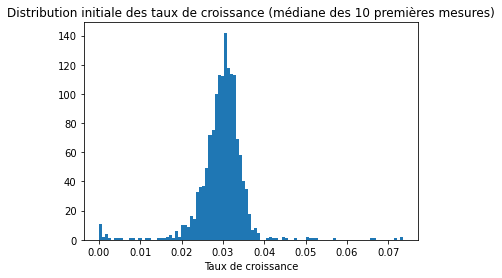

In [16]:
plt.hist(growthR_init, bins=100)
plt.title("Distribution initiale des taux de croissance (médiane des 10 premières mesures)")
plt.xlabel("Taux de croissance")
plt.show()

# Simulation réaliste

## Tirage des effets des mutations

- Paramètres utilisés pour la simulation

In [17]:
# Générer des mutations
mutation_rate = 0.32/60   # nombre de mutations par minute, estimation pour mutH (mutH: ~0.32 mutation/heure)
exp_duration = 4000       # durée de l'expérience, en minutes
mut_shape = (int(exp_duration*mutation_rate*5), 1476)  # nombre de mutations à tirer dans chacun des 1476 canaux de l'expérience
lethal_mut_proba = 0.01   # fraction de mutation létales (estimée à 1% dans l'article)
constant_mut_rate = False # on choisit si le taux de mutation est constant

# Temps de mesure des taux de croissance, comme dans l'article (toutes les 4 minutes sur 4000 minutes)
time = np.arange(0, 4000, 4, dtype=float)

# Bruit sur les mesures
sd_noise = 0.15          # Écart-type bruit additif gaussien

- Tirer dans une DFE donnée l'effet relatif de chacune des mutations sur le taux de croissance

In [18]:
# Paramètres de la distribution Beta fittée comme DFE dans l'article
alpha=0.0074
beta=2.4

esp=alpha/(alpha+beta)
var=alpha*beta/((alpha+beta)**2*(alpha+beta+1))
asym=2*(beta-alpha)*np.sqrt(alpha+beta+1)/((alpha+beta+2)*np.sqrt(alpha*beta))
kurtosis=6*(beta-alpha)**2*(alpha+beta+1)-alpha*beta*(alpha+beta+2)/(alpha*beta*(alpha+beta+2)*(alpha+beta+3))

print("Espérance de la loi simulée:",esp)
print("Espérance à obtenir: 0.0031")
print("CV de la loi simulée:",np.sqrt(var)/esp)
print("CV à obtenir: 9.5")
print("Asymétrie de la loi simulée:",asym)
print("Asymétrie à obtenir: 16.6")
print("Kurtosis de la loi simulée:",kurtosis)
print("Kurtosis à obtenir: 360")

Espérance de la loi simulée: 0.0030738556118634214
Espérance à obtenir: 0.0031
CV de la loi simulée: 9.756143991277604
CV à obtenir: 9.5
Asymétrie de la loi simulée: 15.038610302529994
Asymétrie à obtenir: 16.6
Kurtosis de la loi simulée: 116.8497466871635
Kurtosis à obtenir: 360


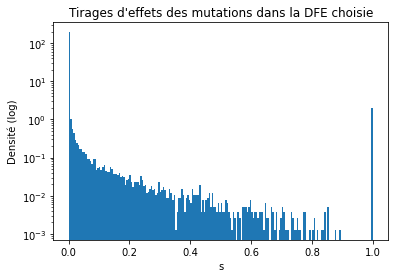

In [19]:
np.random.seed(1)    # graîne pour les générateurs aléatoires

# Combiner différentes densités pour former une DFE mixte
dty_mix = (np.random.beta(alpha, beta, mut_shape),           # distribution beta inférée dans l'article
           np.ones(mut_shape))                               # mutations létales
#dty_mix = (np.random.beta(alpha1,beta1, mut_shape),
#           np.random.beta(alpha2,beta2, mut_shape),
#           np.ones(mut_shape))                               

weights = np.array([1-lethal_mut_proba, lethal_mut_proba])   # poids de chaque densité
#weights = np.array([(1-lethal_mut_proba)/2,(1-lethal_mut_proba)/2, lethal_mut_proba])   # poids de chaque densité

s = np.choose(np.random.choice(np.arange(len(dty_mix)), p=weights, size=mut_shape), choices = dty_mix)

plt.hist(np.concatenate(s), bins=200, log=True, density=True)
plt.title("Tirages d'effets des mutations dans la DFE choisie")
plt.xlabel("s")
plt.ylabel("Densité (log)")
plt.show()

In [20]:
from scipy.stats import skew, kurtosis

print("Empirical moments with lethal mutations")
print("Mean (%) : ", round(np.mean(s)*100, 1))
print("CV : ", round(np.std(s)/np.mean(s), 1))
print("Skewness : ", round(skew(s, axis=None), 1))
print("Kurtosis : ", round(kurtosis(s, axis=None), 1))

Empirical moments with lethal mutations
Mean (%) :  1.3
CV :  7.9
Skewness :  8.9
Kurtosis :  80.2


In [21]:
from scipy.stats import skew, kurtosis

print("Empirical moments without lethal mutations")
print("Mean (%) : ", round(np.mean(s[s<1])*100, 1))
print("CV : ", round(np.std(s[s<1])/np.mean(s[s<1]), 1))
print("Skewness : ", round(skew(s[s<1], axis=None), 1))
print("Kurtosis : ", round(kurtosis(s[s<1], axis=None), 1))

Empirical moments without lethal mutations
Mean (%) :  0.3
CV :  9.9
Skewness :  15.2
Kurtosis :  280.6


In [22]:
# Effets relatifs des mutations sur la fitness
fitness_effects = (1 - s)
fitness_effects

array([[1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       ...,
       [0.99935112, 1.        , 1.        , ..., 1.        , 1.        ,
        0.99999995],
       [0.99972376, 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]])

$\to$ Attention aux approximations numériques : suppression de la plupart des mutations les plus faibles (ne devrait pas être un problème)

## Evolution des taux de mutation

- Simuler l'évolution du taux de croissance après chaque mutation

In [23]:
cumulative_fitness_effects = np.cumprod(fitness_effects, axis=0)          # effets relatifs cumulés des mutations
growthR_steps_sim = np.vstack((growthR_init, cumulative_fitness_effects*growthR_init))   # évolution du taux de croissance mutation par mutation

growthR_steps_sim

array([[0.03247045, 0.03284871, 0.0281195 , ..., 0.02662032, 0.02952523,
        0.02556724],
       [0.03247045, 0.03284871, 0.0281195 , ..., 0.02662032, 0.02952523,
        0.02556724],
       [0.03247045, 0.03284871, 0.0281195 , ..., 0.02662032, 0.02952523,
        0.02556724],
       ...,
       [0.        , 0.03221223, 0.        , ..., 0.        , 0.01285807,
        0.        ],
       [0.        , 0.03221223, 0.        , ..., 0.        , 0.01285807,
        0.        ],
       [0.        , 0.03221223, 0.        , ..., 0.        , 0.01285807,
        0.        ]])

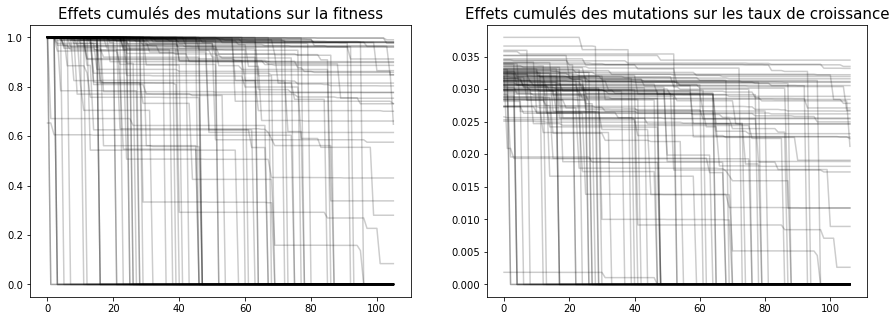

In [24]:
im,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.plot(cumulative_fitness_effects[:,:100], color="black", alpha=0.2)
ax1.set_title("Effets cumulés des mutations sur la fitness",fontsize=15)
ax2.plot(growthR_steps_sim[:,:100], color="black", alpha=0.2)
ax2.set_title("Effets cumulés des mutations sur les taux de croissance",fontsize=15)
plt.show()

- Tirer des intervalles exponentiels entre 2 mutations pour chacun des 1476 canaux, de manière à largement dépasser les 4000 minutes de l'expérience en cumulé.

In [25]:
np.random.seed(1)

if constant_mut_rate : # taux de mutation constant dans le temps et entre les cellules
    exponential_intervals = np.random.exponential(1/mutation_rate, mut_shape)  # durées entre 2 mutations
    #print(exponential_intervals)
else :                 # taux de mutation décroissant avec le taux de croissance (cycle cellulaire et réplication ralentis)
    mutation_rate_t = growthR_steps_sim[:-1]/np.mean(growthR_init) * mutation_rate
    exponential_intervals = np.random.exponential(1/mutation_rate_t)
    exponential_intervals[np.isinf(exponential_intervals)] = exp_duration

mutation_time = np.cumsum(exponential_intervals, axis=0)  # temps d'apparition de chaque mutation, en minutes
print(np.shape(mutation_time))

#plt.hist(mutation_time[-1,:])
#plt.vlines(exp_duration, 0, 300, colors="red", linestyles="dashed")
#plt.title("Distribution des durées d'expériences in silico")
#plt.xlabel("Temps (min)")
#plt.show()

# Vérifier que toutes les expériences in silico sont plus longues que l'expérience réelle, pour pouvoir tronquer
assert min(mutation_time[-1,:]) > exp_duration, "Ajouter plus de mutations, simulations trop courtes : " + str(mutation_time[-1,mutation_time[-1,:]<exp_duration])

(106, 1476)


/Users/jeje/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


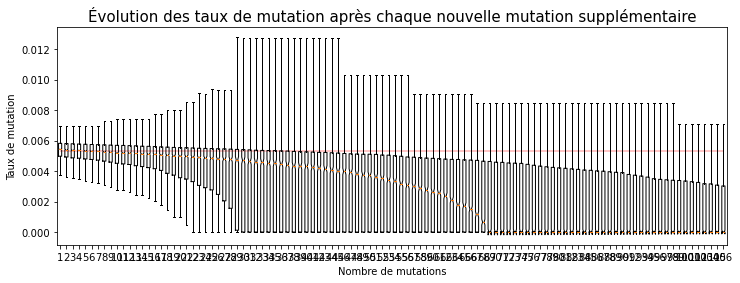

In [26]:
im, ax = plt.subplots(1,1,figsize=(12,4))
ax.hlines(y = mutation_rate, xmin = 1, xmax = np.shape(mutation_rate_t)[0], alpha=0.3, color="red")
ax.boxplot(mutation_rate_t.T, notch=True, sym="")
ax.set_title("Évolution des taux de mutation après chaque nouvelle mutation supplémentaire",fontsize=15)
ax.set(xlabel="Nombre de mutations", ylabel="Taux de mutation")
plt.show()

- Combiner l'évolution du taux de croissance mutation par mutation et les intervalles entre 2 mutations pour obtenir la véritable évolution des taux de croissance

In [27]:
growthR_sim = []
for i in range (0, np.shape(mutation_time)[1]):  # pour chaque expérience
    # Identifier après quelle mutation la mesure est faite
    cond = np.array([time<t for t in mutation_time[:,i]]) & np.array([time>=t for t in np.concatenate(([0],mutation_time[:-1,i]))])
    # Prendre la valeur de taux de croissance associé à cette mutation
    growthR_sim.append(np.piecewise(time, condlist = cond, funclist = growthR_steps_sim[1:,i]))

growthR_sim = np.array(growthR_sim).T

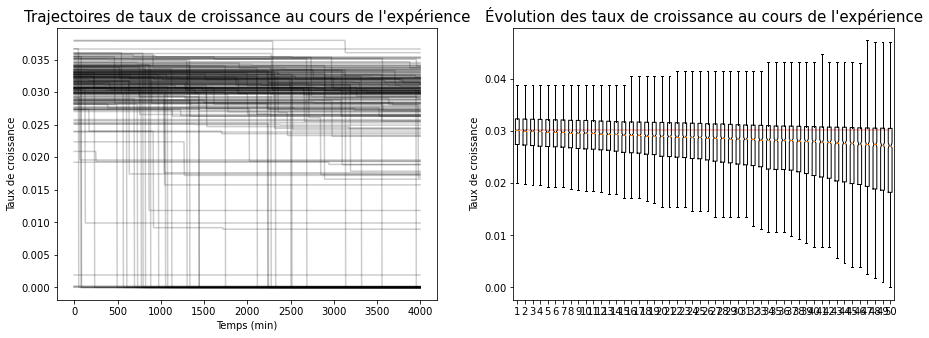

In [28]:
im, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(time, growthR_sim[:,:200], color="black", alpha=0.2)
ax[0].set_title("Trajectoires de taux de croissance au cours de l'expérience",fontsize=15)
ax[0].set(xlabel="Temps (min)", ylabel="Taux de croissance")

ax[1].hlines(y = np.median(growthR_init), xmin = 1, xmax = np.shape(growthR_sim)[0]/20, alpha=0.3, color="red")
ax[1].boxplot(growthR_sim.T[:,range(0,np.shape(growthR_sim)[0],20)], notch=True, sym="")
ax[1].set_title("Évolution des taux de croissance au cours de l'expérience",fontsize=15)
ax[1].set(ylabel="Taux de croissance")
plt.show()

## Bruit proche de celui de l'expérience

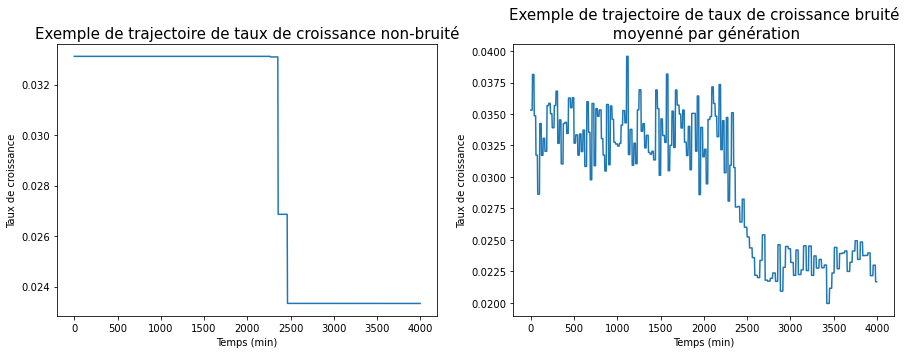

In [35]:
def average_by_generation(growthR, sd_noise=0):
    # Cumulative growth of the cell (exponential coefficient = growth rate x (nbPictures x 4min/picture))
    cum_growth = np.cumsum(growthR*4, axis=0)
    # Total growth at the end of the experiment
    final_growth = cum_growth[-1]
    # The cell divides each time it doubles in size, i.e. every ln(2) increase in growth coefficient
    divisions = (np.arange(final_growth//np.log(2)+2))*np.log(2)
    #print(divisions)
    # Generation = interval between between 2 divisions
    generations_masks = [np.logical_and(cum_growth>=divisions[i-1], cum_growth<divisions[i]) for i in range(1,len(divisions))]
    # Length of each generation
    generation_lengths = np.sum(generations_masks, axis=1)
    # Add multiplicative measurement noise (facultative)
    if sd_noise != 0 :
        growthR = growthR*(1+np.random.normal(0, sd_noise, size=np.shape(growthR)))
    # Average the growth rates during each generation
    growthR_genAverage = [np.mean(growthR[generation]) for generation in generations_masks]
    return (np.repeat(growthR_genAverage, repeats=generation_lengths))

growthR_sim_noise = np.array([average_by_generation(growthR, sd_noise) for growthR in growthR_sim.T]).T

im, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(time, growthR_sim[:,20])
ax[0].set_title("Exemple de trajectoire de taux de croissance non-bruité",fontsize=15)
ax[0].set(xlabel="Temps (min)", ylabel="Taux de croissance")

ax[1].plot(time, growthR_sim_noise[:,20])
ax[1].set_title("Exemple de trajectoire de taux de croissance bruité\n moyenné par génération",fontsize=15)
ax[1].set(xlabel="Temps (min)", ylabel="Taux de croissance")
plt.show()

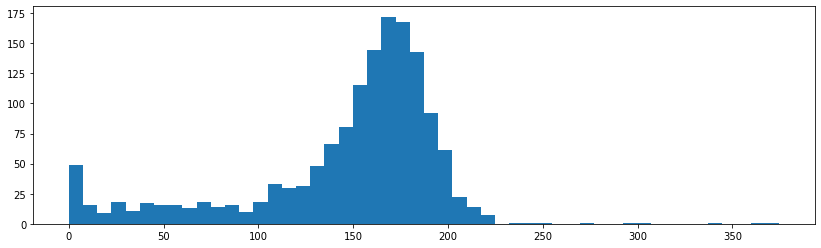

In [36]:
im, ax = plt.subplots(1,1,figsize=(14,4))
ax.hist(np.sum(growthR_sim*4, axis=0)/np.log(2), bins=50)
plt.show()

## Figure bilan

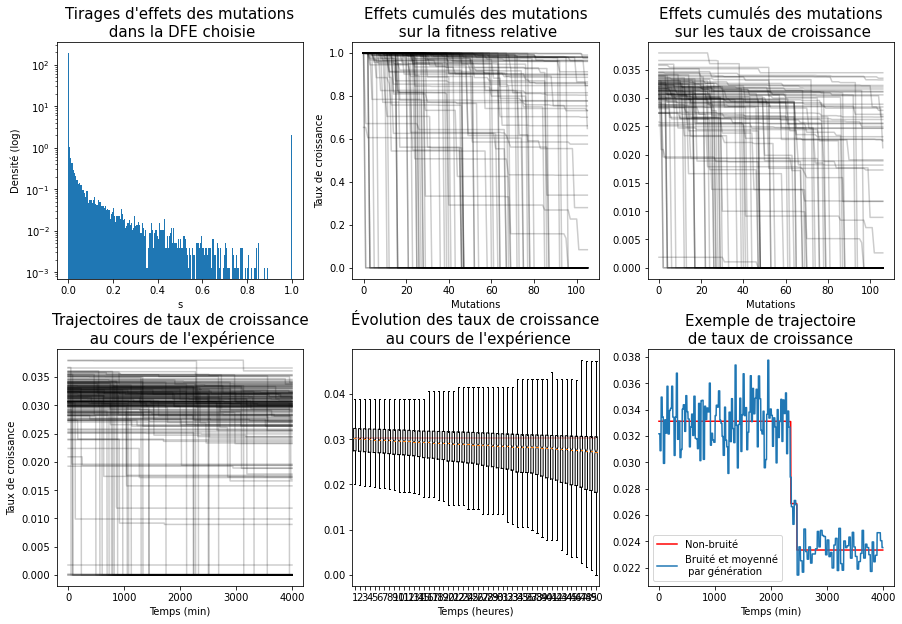

In [24]:
im,ax = plt.subplots(2,3,figsize=(15,10))

ax[0,0].hist(np.concatenate(s), bins=200, log=True, density=True)
ax[0,0].set_title("Tirages d'effets des mutations\n dans la DFE choisie",fontsize=15)
ax[0,0].set(xlabel="s", ylabel="Densité (log)")
ax[0,1].plot(cumulative_fitness_effects[:,:100], color="black", alpha=0.2)
ax[0,1].set_title("Effets cumulés des mutations\n sur la fitness relative",fontsize=15)
ax[0,1].set(xlabel="Mutations", ylabel="Taux de croissance")
ax[0,2].plot(growthR_steps_sim[:,:100], color="black", alpha=0.2)
ax[0,2].set_title("Effets cumulés des mutations\n sur les taux de croissance",fontsize=15)
ax[0,2].set(xlabel="Mutations")
ax[1,0].plot(time, growthR_sim[:,:200], color="black", alpha=0.2)
ax[1,0].set_title("Trajectoires de taux de croissance\n au cours de l'expérience",fontsize=15)
ax[1,0].set(xlabel="Temps (min)", ylabel="Taux de croissance")
ax[1,1].hlines(y = np.median(growthR_init), xmin = 1, xmax = np.shape(growthR_sim)[0]/20, alpha=0.3, color="red")
ax[1,1].boxplot(growthR_sim.T[:,range(0,np.shape(growthR_sim)[0],20)], notch=True, sym="")
ax[1,1].set_title("Évolution des taux de croissance\n au cours de l'expérience",fontsize=15)
ax[1,1].set(xlabel="Temps (heures)")
ax[1,2].plot(time, growthR_sim[:,20], color="red", label = "Non-bruité")
ax[1,2].plot(time, growthR_sim_noise[:,20], label = "Bruité et moyenné\n par génération")
ax[1,2].set_title("Exemple de trajectoire\n de taux de croissance ",fontsize=15)
ax[1,2].set(xlabel="Temps (min)")
ax[1,2].legend()
im.subplots_adjust(hspace=0.3)
plt.savefig("Img/Simulations.png", bbox_inches='tight')
plt.show()

# Animations

In [25]:
from scipy.stats import gaussian_kde

In [26]:
xmin=0
xmax=0.14
ymin=0
ymax=250
nbreaks=200

tmax=1000


In [27]:
def get_y(x,growthR_cur,eps): # trouve la hauteur de la barre de l'histogramme correspondant à [x-eps/2,x+eps/2]
    y=[]
    i=0
    j=0
    for x_cur in x:
        while x_cur-growthR_cur[i]>eps/2 and i<len(growthR_cur)-1: i+=1
        while growthR_cur[j]-x_cur<eps/2 and j<len(growthR_cur)-1: j+=1
        y+=[j-i]
    return y

def get_dist_s(growthR_real): # calcul de tous les effets entre chaque mesure (inclut les non-effets en cas de non-division)
    s=[]
    for i in range(2,len(growthR_real)-1):
        for j in range(len(growthR_real[i])): 
            wv=(growthR_real[i])[j]
            wn=(growthR_real[i+1])[j]
            if wv!=0:
                s+=[(wv-wn)/wv]
    return s

def sort_rows(w): # pour optimiser la construction de l'histogramme
    res=[]
    for row in w:
        res+=[np.sort(row)]
    return res
    
def analyse_ligne(row): 
    res=[]
    for i in range(int(len(row)/3-1)):
        if(row[3*i+2]!="NA"):
            nouv=float(row[3*i+2].replace(",","."))
            if nouv<seuil_detection_fitness: nouv=0
            res+=[nouv]
        else:
            res+=[0] # JJ   attention, pb à régler un jour!
    return res

In [29]:
fig, ax = plt.subplots(figsize=(15,5))
line1,line2,=ax.plot([], [], [], [])
line = [line1,line2]
ax.set(xlabel = "Taux de croissance au temps t", ylabel = "Nombre d'individus")
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
plt.close()

def init():
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.grid(True)
    return line,

In [30]:
ax.legend(["Processus simulé","Processus observé"])

def update(frame): # met à jour l'affichage
    x=np.linspace(xmin,xmax,nbreaks)
    y_sim=get_y(x,np.sort(growthR_sim[frame]),eps=(xmax-xmin)/nbreaks)
    y_real=get_y(x,np.sort(growthR_real_array[frame]),eps=(xmax-xmin)/nbreaks)
    line1.set_data(x,y_sim)
    line2.set_data(x,y_real)
    titre=""
    titre+="t="+str(int(frame*4/60))+"h"
    titre+="    (frame="+str(frame)+")"
    fig.suptitle(titre,size=20)
    return line,

# Lancement :
ani = animation.FuncAnimation(fig, update, 
                              frames=range(tmax), 
                              init_func=init, 
                              blit=False, 
                              repeat=False, 
                              interval=10)

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=100, bitrate=1000)
ani.save('Video/GrowthRates_simulations_VS_observations.mp4', writer=writer)

Video('Video/GrowthRates_simulations_VS_observations.mp4')

In [31]:
ax.legend(["Processus simulé bruité","Processus observé"])

def update(frame): # met à jour l'affichage
    x=np.linspace(xmin,xmax,nbreaks)
    y_sim_noise=get_y(x,np.sort(growthR_sim_noise[frame]),eps=(xmax-xmin)/nbreaks)
    y_real=get_y(x,np.sort(growthR_real_array[frame]),eps=(xmax-xmin)/nbreaks)
    line1.set_data(x,y_sim_noise)
    line2.set_data(x,y_real)
    titre=""
    titre+="t="+str(int(frame*4/60))+"h"
    titre+="    (frame="+str(frame)+")"
    fig.suptitle(titre,size=20)
    return line,

# Lancement :
ani = animation.FuncAnimation(fig, update, 
                              frames=range(tmax), 
                              init_func=init, 
                              blit=False, 
                              repeat=False, 
                              interval=10)

ani.save('Video/GrowthRates_noisySimulations_VS_observations.mp4', writer=writer)
Video('Video/GrowthRates_noisySimulations_VS_observations.mp4')

In [32]:
ax.legend(["Processus simulé lissé","Processus observé lissé"])

def update(frame): # met à jour l'affichage
    x=np.linspace(xmin,xmax,nbreaks)
    y_sim_density = gaussian_kde(growthR_sim[frame])
    y_sim_density.covariance_factor = lambda : 0.1
    y_sim_density._compute_covariance()
    y_real_density = gaussian_kde(growthR_real_array[frame][np.isfinite(growthR_real_array[frame])])
    y_real_density.covariance_factor = lambda : 0.1
    y_real_density._compute_covariance()
    line1.set_data(x,y_sim_density(x))
    line2.set_data(x,y_real_density(x))
    titre=""
    titre+="t="+str(int(frame*4/60))+"h"
    titre+="    (frame="+str(frame)+")"
    fig.suptitle(titre,size=20)
    return line,

# Lancement :
ani = animation.FuncAnimation(fig, update, 
                              frames=range(tmax), 
                              init_func=init, 
                              blit=False, 
                              repeat=False, 
                              interval=10)

ani.save('Video/GrowthRates_smoothedSimulations_VS_smoothedObservations.mp4', writer=writer)
Video('Video/GrowthRates_smoothedSimulations_VS_smoothedObservations.mp4')

In [33]:
ax.legend(["Processus simulé bruité lissé","Processus observé lissé"])

def update(frame): # met à jour l'affichage
    x=np.linspace(xmin,xmax,nbreaks)
    y_sim_density = gaussian_kde(growthR_sim_noise[frame])
    y_sim_density.covariance_factor = lambda : 0.1
    y_sim_density._compute_covariance()
    y_real_density = gaussian_kde(growthR_real_array[frame][np.isfinite(growthR_real_array[frame])])
    y_real_density.covariance_factor = lambda : 0.1
    y_real_density._compute_covariance()
    line1.set_data(x,y_sim_density(x))
    line2.set_data(x,y_real_density(x))
    titre=""
    titre+="t="+str(int(frame*4/60))+"h"
    titre+="    (frame="+str(frame)+")"
    fig.suptitle(titre,size=20)
    return line,

# Lancement :
ani = animation.FuncAnimation(fig, update, 
                              frames=range(tmax), 
                              init_func=init, 
                              blit=False, 
                              repeat=False, 
                              interval=10)

ani.save('Video/GrowthRates_smoothedNoisySimulations_VS_smoothedObservations.mp4', writer=writer)
Video('Video/GrowthRates_smoothedNoisySimulations_VS_smoothedObservations.mp4')

$\to$ L'évolution de la distribution des taux de croissance simulés est assez proche de celle des taux observés au début, mais à la fin les deux divergent, probablement à cause de la DFE non adaptée (trop peu de mutations fortement délétères avec la Beta) et le début de la sénescence des cellules (après 40h).

## Réplicats

<ipython-input-34-266511330491>:42: RuntimeWarning: divide by zero encountered in true_divide
  exponential_intervals = np.random.exponential(1/mutation_rate_t)


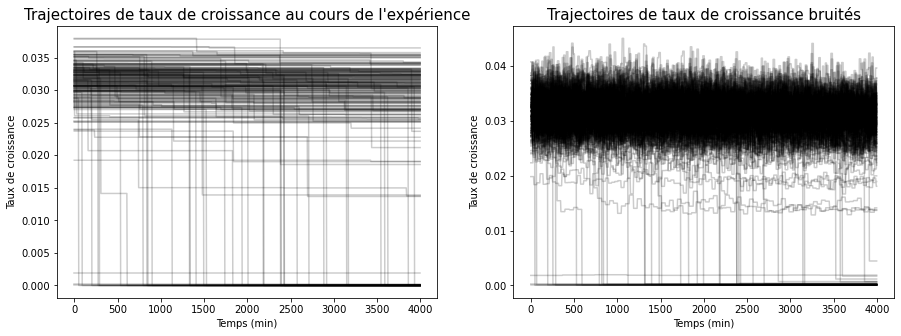

In [34]:
def sim_B_growth (growthR_init, time, dty_mix, dty_weights, mut_shape, sd_noise, constant_mut_rate, mutation_rate, seed=np.random.randint(10000)):
    """Simule des expériences de croissance bactérienne

    Parameters:
    growthR_init (array): taux de croissance initiaux (pour chaque microcanal)
    dty_mix (tuple): mélange de densités représentant la DFE
    dty_weights (tuple): poids de chacune des densités
    mut_shape (tuple): forme du tableau des taux de croissance en sortie (nombre de mesures x nombre de canaux)
    sd_noise (float): écart-type du bruit Gaussien sur les mesures
    constant_mut_rate (bool): si Vrai le taux de mutation est constant, sinon il dépend du taux de croissance
    mutation_rate (float): taux de mutation
    seed (float): graîne pour les générateurs aléatoires 

    Returns:
    int:Returning value

   """
    
    np.random.seed(seed)
    
    # Alonger artificiellement l'expérience afin d'éliminer les dernières mesures biaisées (car le moyennage sur la fin de la génération n'est pas permis)
    exp_duration = time[-1]
    time = np.concatenate([time, np.arange(exp_duration+4, exp_duration+4*10+1, 4)])
    
    # DFE
    s = np.choose(np.random.choice(np.arange(len(dty_mix)), p=dty_weights, size=mut_shape), choices = dty_mix)

    # Effets relatifs des mutations sur la fitness
    fitness_effects = (1 - s)
    
    # Effets relatifs cumulés des mutations
    cumulative_fitness_effects = np.cumprod(fitness_effects, axis=0)
    
    # Évolution du taux de croissance, mutation par mutation
    growthR_steps_sim = np.vstack((growthR_init, cumulative_fitness_effects*growthR_init))
        
    # Durées entre 2 mutations
    if constant_mut_rate : # taux de mutation constant dans le temps et entre les cellules
        exponential_intervals = np.random.exponential(1/mutation_rate, mut_shape)  # durées entre 2 mutations
    else :                 # taux de mutation décroissant avec le taux de croissance (cycle cellulaire et réplication ralentis)
        mutation_rate_t = growthR_steps_sim[:-1]/np.mean(growthR_init) * mutation_rate
        exponential_intervals = np.random.exponential(1/mutation_rate_t)
        exponential_intervals[np.isinf(exponential_intervals)] = exp_duration
    # Temps d'apparition de chaque mutation
    mutation_time = np.cumsum(exponential_intervals, axis=0)
    # Vérifier que toutes les expériences in silico sont plus longues que l'expérience réelle, pour pouvoir tronquer
    assert min(mutation_time[-1,:]) > exp_duration, "Ajouter plus de mutations, simulations trop courtes : " + str(mutation_time[:,mutation_time[-1,:]<exp_duration])
    
    # Évolution du taux de croissance au cours du temps
    growthR_sim = []
    for i in range (0, np.shape(mutation_time)[1]):  # pour chaque expérience
        # Identifier après quelle mutation la mesure est faite
        cond = np.array([time<t for t in mutation_time[:,i]]) & np.array([time>=t for t in np.concatenate(([0],mutation_time[:-1,i]))])
        # Prendre la valeur de taux de croissance associé à cette mutation
        growthR_sim.append(np.piecewise(time, condlist = cond, funclist = growthR_steps_sim[1:,i]))

    growthR_sim = np.array(growthR_sim).T
    #growthR_sim_noise = growthR_sim*(1+np.random.normal(0, sd_noise, size=np.shape(growthR_sim)))
    growthR_sim_noise = np.array([average_by_generation(growthR, sd_noise) for growthR in growthR_sim.T]).T
    growthR_sim,growthR_sim_noise = growthR_sim[:-10], growthR_sim_noise[:-10]  # retirer les dernières mesures biaisées
    
    return ([growthR_sim, growthR_sim_noise])


# Combiner différentes densités pour former une DFE mixte
dty_mix = (np.random.beta(alpha, beta, mut_shape),           # distribution beta inférée dans l'article
           np.ones(mut_shape))                               # mutations létales
dty_weights = np.array([1-lethal_mut_proba, lethal_mut_proba])   # poids de chaque densité

#dty_mix = (np.random.beta(alpha1,beta1, mut_shape),
#           np.random.beta(alpha2,beta2, mut_shape),
#           np.ones(mut_shape))    
#dty_weights = np.array([(1-lethal_mut_proba)/2,(1-lethal_mut_proba)/2, lethal_mut_proba])   # poids de chaque densité

growthR_sim, growthR_sim_noise = sim_B_growth(growthR_init, time, dty_mix, dty_weights, mut_shape, sd_noise, constant_mut_rate, mutation_rate, seed=0)

im, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(time, growthR_sim[:,:200], color="black", alpha=0.2)
ax[0].set_title("Trajectoires de taux de croissance au cours de l'expérience",fontsize=15)
ax[0].set(xlabel="Temps (min)", ylabel="Taux de croissance")

ax[1].plot(time, growthR_sim_noise[:,:200], color="black", alpha=0.2)
ax[1].set_title("Trajectoires de taux de croissance bruités",fontsize=15)
ax[1].set(xlabel="Temps (min)", ylabel="Taux de croissance")
plt.show()

In [ ]:
replicates = [sim_B_growth(growthR_init, time, dty_mix, dty_weights, mut_shape, sd_noise, 
                           constant_mut_rate, mutation_rate, seed=k) for k in range(100)]
growthR_sim_replicates = np.array(replicates)[:,0]
growthR_sim_noise_replicates = np.array(replicates)[:,1]

<ipython-input-34-266511330491>:42: RuntimeWarning: divide by zero encountered in true_divide
  exponential_intervals = np.random.exponential(1/mutation_rate_t)


In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
line1_LowQ, line1_HighQ, line2,=ax.plot([], [], [], [], [], [])
line = [line1_LowQ, line1_HighQ, line2]
ax.set(xlabel = "Taux de croissance au temps t", ylabel = "Nombre d'individus")
ax.legend(["Processus simulé : quantile 2.5%", "Processus simulé : quantile 97.5%", "Processus observé"])
plt.close()

def init():
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.grid(True)
    return line,

def update(frame): # met à jour l'affichage
    x = np.linspace(xmin,xmax,nbreaks)
    y_sim_replicates = [get_y(x,np.sort(growthR_sim[frame]),eps=(xmax-xmin)/nbreaks) for growthR_sim in growthR_sim_replicates]
    y_sim_LowQ = np.quantile(y_sim_replicates, 0.025, axis=0)
    y_sim_HighQ = np.quantile(y_sim_replicates, 0.975, axis=0)
    y_real = get_y(x,np.sort(growthR_real_array[frame]),eps=(xmax-xmin)/nbreaks)
    
    line1_LowQ.set_data(x, y_sim_LowQ)
    line1_HighQ.set_data(x, y_sim_HighQ)
    line2.set_data(x, y_real)
    
    titre = "t=" + str(int(frame*4/60)) + "h" + "    (frame="+str(frame)+")"
    fig.suptitle(titre,size=20)
    return line,

# Lancement :
ani = animation.FuncAnimation(fig, update, 
                              frames=range(tmax), 
                              init_func=init, 
                              blit=False, 
                              repeat=False, 
                              interval=10)

ani.save('Video/GrowthRates_simulationsInterval_VS_observations.mp4', writer=writer)
Video('Video/GrowthRates_simulationsInterval_VS_observations.mp4')

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
line1_LowQ, line1_HighQ, line2,=ax.plot([], [], [], [], [], [])
line = [line1_LowQ, line1_HighQ, line2]
ax.set(xlabel = "Taux de croissance au temps t", ylabel = "Nombre d'individus")
ax.legend(["Processus simulé bruité : quantile 2.5%", "Processus simulé bruité : quantile 97.5%", "Processus observé"])
plt.close()

def init():
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.grid(True)
    return line,

def update(frame): # met à jour l'affichage
    x = np.linspace(xmin,xmax,nbreaks)
    Y_sim_noise_replicates = [get_y(x,np.sort(growthR_sim_noise[frame]),eps=(xmax-xmin)/nbreaks) for growthR_sim_noise in growthR_sim_noise_replicates]
    Y_sim_noise_LowQ = np.quantile(Y_sim_noise_replicates, 0.025, axis=0)
    Y_sim_noise_HighQ = np.quantile(Y_sim_noise_replicates, 0.975, axis=0)
    y_real = get_y(x,np.sort(growthR_real_array[frame]),eps=(xmax-xmin)/nbreaks)
    
    line1_LowQ.set_data(x, Y_sim_noise_LowQ, color="blue")
    line1_HighQ.set_data(x, Y_sim_noise_HighQ, color="blue")
    line2.set_data(x, y_real, color="orange")
    
    titre = "t=" + str(int(frame*4/60)) + "h" + "    (frame="+str(frame)+")"
    fig.suptitle(titre,size=20)
    return line,

# Lancement :
ani = animation.FuncAnimation(fig, update, 
                              frames=range(tmax), 
                              init_func=init, 
                              blit=False, 
                              repeat=False, 
                              interval=10)

ani.save('Video/GrowthRates_noisySimulationsInterval_VS_observations.mp4', writer=writer)
Video('Video/GrowthRates_noisySimulationsInterval_VS_observations.mp4')